# Pylops - pre-stack inversion with partial stacks

### Author: M.Ravasi

In this notebook we consider the problem of pre-stack or AVO inversion with partial stacks and compare two strategies:

- use middle angle
- model with full angle spectrum (same as data before partial stacking) and stack within modelling operator

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import copy
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve, block_diag
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.signal import filtfilt

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.avo.avo                    import *
from pylops.avo.poststack              import *
from pylops.avo.prestack               import *
from pylops.optimization.leastsquares  import *

## Pre-stack inversion - single interface

Let's start considering a single interface and compute the reflection coefficient using various approximations of the Zoeppritz equation

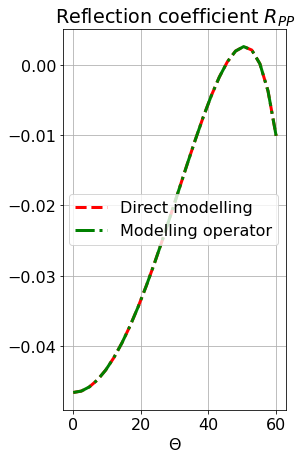

In [2]:
vp1, vs1, rho1 = 2200., 1300., 2000  # upper medium
vp0, vs0, rho0 = 2300., 1400., 2100  # lower medium

ntheta = 26
thetamin, thetamax = 0, 60
theta = np.linspace(thetamin, thetamax, ntheta)

# Create composite parameters
ai0, si0, vpvs0 = vp0*rho0, vs0*rho0, vp0/vs0
ai1, si1, vpvs1 = vp1*rho1, vs1*rho1, vp1/vs1

# Direct modelling
rvp = np.log(vp1) - np.log(vp0)
rvs = np.log(vs1) - np.log(vs0)
rrho = np.log(rho1) - np.log(rho0)
r = np.array([rvp, rvs, rrho])

G1, G2, G3 = akirichards(theta, vs1/vp1)
rpp_direct = G1*rvp + G2*rvs + G3*rrho

# Modelling operator
D = block_diag([-1, 1], [-1, 1], [-1, 1])
G = np.vstack((G1, G2, G3)).T

Mod = np.dot(G, D)

m = np.hstack((np.log(np.array([vp0, vp1])), 
               np.log(np.array([vs0, vs1])),
               np.log(np.array([rho0, rho1]))))
rpp_mod = np.dot(Mod, m)

plt.figure(figsize=(4,7))
plt.plot(theta, rpp_direct, '--r', lw=3, label='Direct modelling')
plt.plot(theta, rpp_mod, '-.g', lw=3, label='Modelling operator')
plt.xlabel(r'$\Theta$')
plt.title(r'Reflection coefficient $R_{PP}$')
plt.grid()
plt.legend();

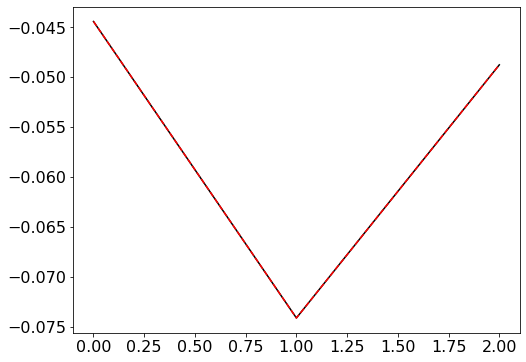

In [3]:
mest = solve(np.dot(Mod.T, Mod) + 1e-10*np.eye(6), np.dot(Mod.T, rpp_mod))
rest = np.dot(D, mest)

plt.figure()
plt.plot(r, 'k')
plt.plot(rest, '--r')

Now we stack some of the angles and use angle in the middle

In [4]:
ntheta_near, ntheta_nid, ntheta_far, ntheta_ufar = 7, 7, 7, 5 

nthetas = np.array([ntheta_near, ntheta_nid, ntheta_far, ntheta_ufar])
ithetas = np.cumsum(nthetas)
ithetas = np.insert(ithetas, 0, 0)

ithetas_mid = (ithetas[1:]+ithetas[:-1])/2
ithetas_mid = ithetas_mid.astype(np.int)

thetas_mid = theta[ithetas_mid]

rpp_mid = rpp_mod[ithetas_mid]
rpp_partial = np.array([np.sum(rpp_mod[ithetas[i]:ithetas[i+1]])/(ithetas[i+1]-ithetas[i]) for i in range(len(ithetas)-1)])

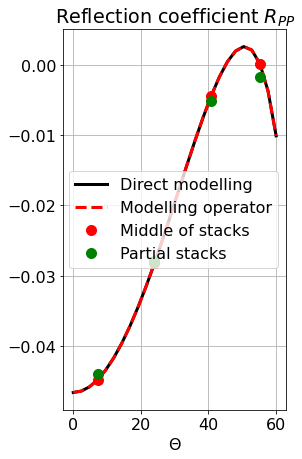

In [5]:
plt.figure(figsize=(4,7))
plt.plot(theta, rpp_direct, 'k', lw=3, label='Direct modelling')
plt.plot(theta, rpp_mod, '--r', lw=3, label='Modelling operator')
plt.plot(thetas_mid, rpp_mid, '.r', ms=20, label='Middle of stacks')
plt.plot(thetas_mid, rpp_partial, '.g', ms=20, label='Partial stacks')
plt.xlabel(r'$\Theta$')
plt.title(r'Reflection coefficient $R_{PP}$')
plt.grid()
plt.legend();

We can now create the modelling operator with these middle angles

In [6]:
G1mid, G2mid, G3mid = akirichards(thetas_mid, vs1/vp1)
Gmid = np.vstack((G1mid, G2mid, G3mid)).T
Modmid = np.dot(Gmid, D)
print(np.dot(Modmid, m) - rpp_mid)

mestmid = solve(np.dot(Modmid.T, Modmid) + 1e-10*np.eye(6), np.dot(Modmid.T, rpp_partial))
restmid = np.dot(D, mestmid)

[0. 0. 0. 0.]


Alternatively make create a modelling operator that mimics the stacks

[-1.26981758e-15  3.81639165e-16  3.17454396e-16  1.77635684e-15]


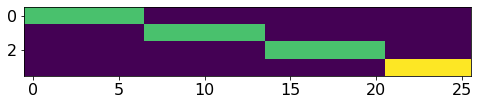

In [7]:
S = block_diag(*[np.ones(npartial)/npartial for npartial in nthetas])
plt.imshow(S)

Modpartial = np.dot(S, np.dot(G, D))
print(np.dot(Modpartial, m) - rpp_partial)

mestpartial = solve(np.dot(Modpartial.T, Modpartial) + 1e-10*np.eye(6), np.dot(Modpartial.T, rpp_partial))
restpartial = np.dot(D, mestpartial)

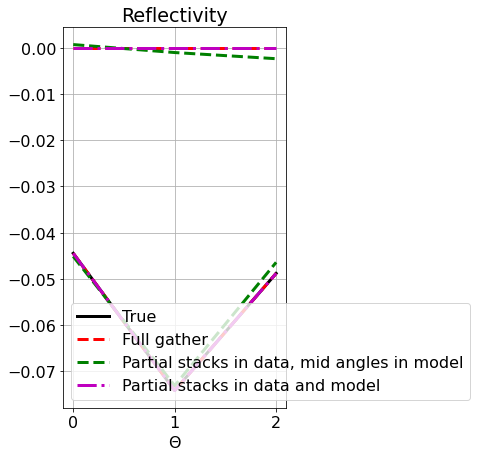

In [8]:
plt.figure(figsize=(4,7))
plt.plot(r, 'k', lw=3, label='True')
plt.plot(rest, '--r', lw=3, label='Full gather')
plt.plot(restmid,'--g', lw=3, label='Partial stacks in data, mid angles in model')
plt.plot(restpartial,'-.m', lw=3, label='Partial stacks in data and model')
plt.plot(r-rest, '--r', lw=3)
plt.plot(r-restmid,'--g', lw=3)
plt.plot(r-restpartial,'-.m', lw=3)
plt.xlabel(r'$\Theta$')
plt.title('Reflectivity')
plt.grid()
plt.legend();

## Pre-stack inversion - 1D

Create velocity and density profiles

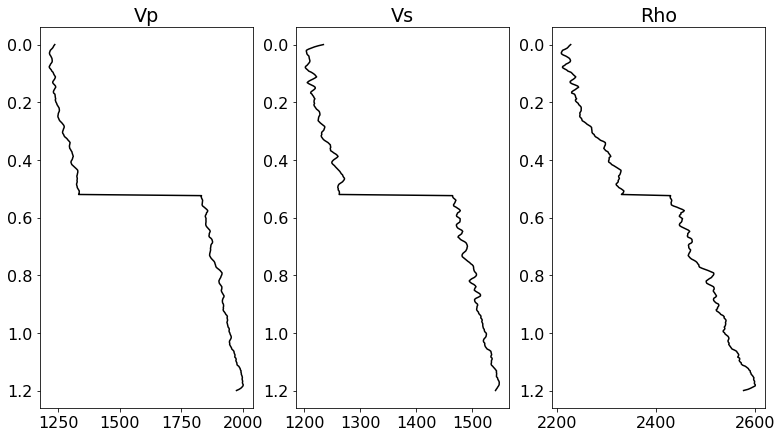

In [9]:
np.random.seed(0)

nt0 = 301
dt0 = 0.004

t0  = np.arange(nt0)*dt0
vp  = 1200 + np.arange(nt0) + filtfilt(np.ones(5)/5.,1,np.random.normal(0, 20, nt0))
vs  = 600  + vp/2           + filtfilt(np.ones(5)/5.,1,np.random.normal(0, 10, nt0))
rho = 1000 + vp             + filtfilt(np.ones(5)/5.,1,np.random.normal(0, 8, nt0))
vp[131:]+=500
vs[131:]+=200
rho[131:]+=100

fig, axs = plt.subplots (1, 3, figsize=(13,7))
axs[0].plot(vp,  t0, 'k')
axs[0].set_title('Vp')
axs[0].invert_yaxis()
axs[1].plot(vs,  t0, 'k')
axs[1].set_title('Vs')
axs[1].invert_yaxis()
axs[2].plot(rho, t0, 'k')
axs[2].set_title('Rho')
axs[2].invert_yaxis()

Define angles, wavelet and background VS/VP

In [10]:
ntwav = 41
wav = ricker(t0[:ntwav//2+1], 15)[0]

vsvp   = 0.5
vsvp_z = np.linspace(0.4, 0.6, nt0)

m = np.stack((np.log(vp), np.log(vs), np.log(rho)),axis=1)

Create linear pre-stack modelling operator

In [11]:
PPop = PrestackLinearModelling(wav, theta, vsvp=vsvp, nt0=nt0, 
                               linearization='akirich', explicit=True)
dottest(PPop, nt0*ntheta, nt0*3, verb=True);

Dot test passed, v^H(Opu)=-35.008852696555124 - u^H(Op^Hv)=-35.00885269655511


Create data

In [12]:
dPP = PPop*m.T.flatten()
dPP = dPP.reshape(ntheta, nt0).T

Create operator for partial stacks (using middle angles)

In [13]:
PPmidop = PrestackLinearModelling(wav, thetas_mid, vsvp=vsvp, nt0=nt0, linearization='akirich', explicit=True)

Create operator for partial stacks with explicit sum

In [14]:
Stack = block_diag(*[np.hstack([np.eye(nt0)/npartial]*npartial) for npartial in nthetas])
PPpartialop = MatrixMult(np.dot(Stack, PPop.A))

# lop
#Stack = block_diag(*[np.ones(npartial)/npartial for npartial in nthetas])
#S = Transpose((nt0, len(nthetas)), (0, 1)) * MatrixMult(Stack, (nt0)) * Transpose((nt0, ntheta), (0, 1))

Compare the different data

1.1237423355005876
0.0
1.151912347795837
2.120770855584622e-14


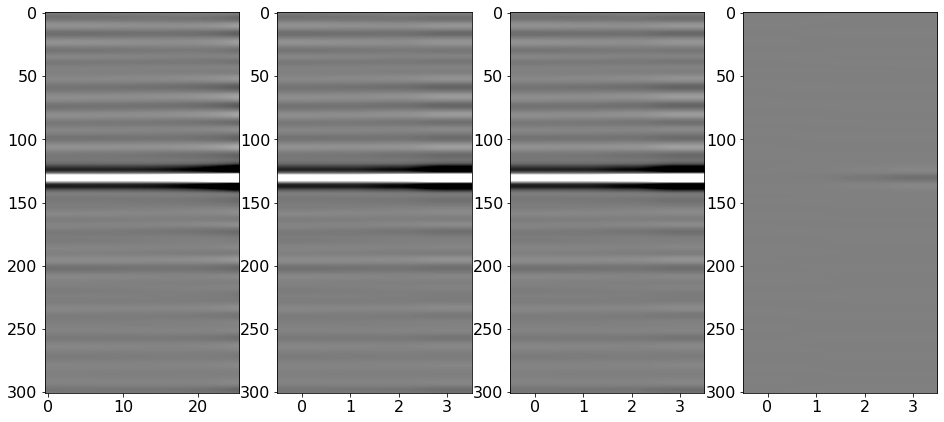

In [15]:
dPPmid = dPP[:, ithetas_mid] # (PPpartialop * m.T.flatten()).reshape(4, nt0).T
print(np.linalg.norm(dPP[:, ithetas_mid]))
print(np.linalg.norm(dPP[:, ithetas_mid] - (PPmidop * m.T.flatten()).reshape(4, nt0).T))

#dPPpartial = PPpartialop * m.T.flatten()
#dPPpartial = dPPpartial.reshape(4, nt0).T
dPPpartial = np.array([np.sum(dPP[:, ithetas[i]:ithetas[i+1]], axis=1)/(ithetas[i+1]-ithetas[i]) 
                       for i in range(len(ithetas)-1)]).T
print(np.linalg.norm(dPPpartial))
print(np.linalg.norm(dPPpartial - (PPpartialop * m.T.flatten()).reshape(4, nt0).T))

clip=0.2
fig, axs = plt.subplots(1, 4, figsize=(16, 7))
axs[0].imshow(dPP, cmap='gray', vmin=-clip*dPP.max(), vmax=clip*dPP.max())
axs[0].axis('tight')
axs[1].imshow(dPPmid, cmap='gray', vmin=-clip*dPP.max(), vmax=clip*dPP.max())
axs[1].axis('tight')
axs[2].imshow(dPPpartial, cmap='gray', vmin=-clip*dPP.max(), vmax=clip*dPP.max())
axs[2].axis('tight')
axs[3].imshow(dPPmid - dPPpartial, cmap='gray', vmin=-clip*dPP.max(), vmax=clip*dPP.max())
axs[3].axis('tight');

Create background model and invert back for model

In [16]:
nsmooth = 50
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m, axis=0)

dPP_0 = PPop * mback.T.flatten()
dPP_r = dPP.T.flatten() - dPP_0

dPPmid_0 = PPmidop * mback.T.flatten()
dPmid_r = dPPpartial.T.flatten() - dPPmid_0

dPPpartial_0 = PPpartialop * mback.T.flatten()
dPPpartial_r = dPPpartial.T.flatten() - dPPpartial_0

minv = lstsq(PPop.A, dPP_r, cond=1e-5)[0]
minv = minv.reshape(3, nt0).T
minv = mback + minv

minvmid = lstsq(PPmidop.A, dPmid_r, cond=1e-5)[0]
minvmid = minvmid.reshape(3, nt0).T
minvmid = mback + minvmid

minvpartial = lstsq(PPpartialop.A, dPPpartial_r, cond=1e-5)[0]
minvpartial = minvpartial.reshape(3, nt0).T
minvpartial = mback + minvpartial

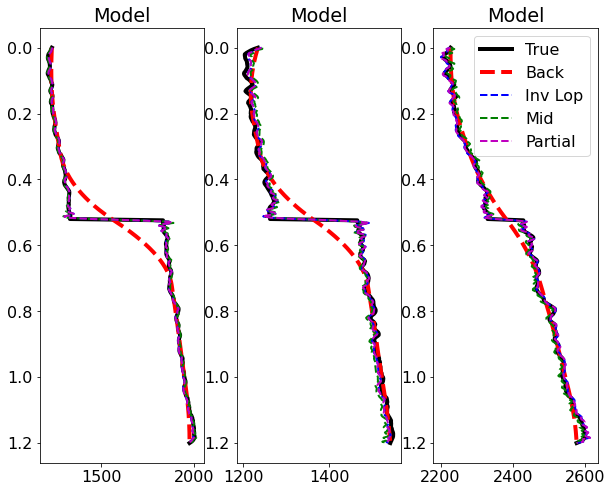

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(10, 8))
axs[0].plot(vp, t0, 'k', lw=4, label='True')
axs[0].plot(np.exp(mback[:, 0]), t0, '--r', lw=4, label='Back')
axs[0].plot(np.exp(minv[:, 0]), t0, '--b', lw=2, label='Inv Lop')
axs[0].plot(np.exp(minvmid[:, 0]), t0, '--g', lw=2, label='Mid')
axs[0].plot(np.exp(minvpartial[:, 0]), t0, '--m', lw=2, label='Partial')
axs[0].set_title('Model')
axs[0].invert_yaxis()
axs[1].plot(vs, t0, 'k', lw=4, label='True')
axs[1].plot(np.exp(mback[:, 1]), t0, '--r', lw=4, label='Back')
axs[1].plot(np.exp(minv[:, 1]), t0, '--b', lw=2, label='Inv Lop')
axs[1].plot(np.exp(minvmid[:, 1]), t0, '--g', lw=2, label='Mid')
axs[1].plot(np.exp(minvpartial[:, 1]), t0, '--m', lw=2, label='Partial')
axs[1].set_title('Model')
axs[1].invert_yaxis()
axs[1].axis('tight')
axs[2].plot(rho, t0, 'k', lw=4, label='True')
axs[2].plot(np.exp(mback[:, 2]), t0, '--r', lw=4, label='Back')
axs[2].plot(np.exp(minv[:, 2]), t0, '--b', lw=2, label='Inv Lop')
axs[2].plot(np.exp(minvmid[:, 2]), t0, '--g', lw=2, label='Mid')
axs[2].plot(np.exp(minvpartial[:, 2]), t0, '--m', lw=2, label='Partial')
axs[2].set_title('Model')
axs[2].invert_yaxis()
axs[2].axis('tight')
axs[2].legend();

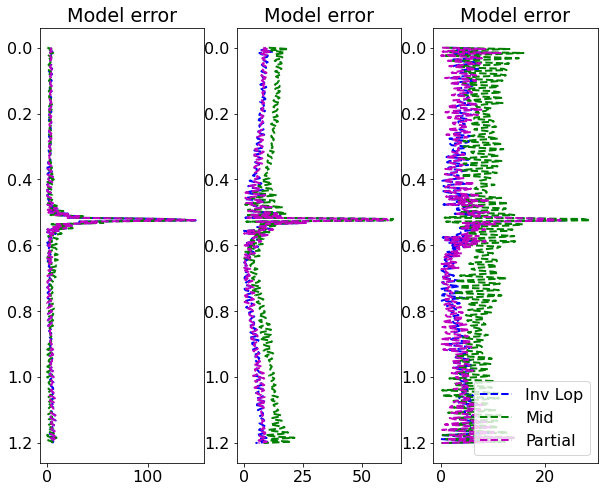

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(10, 8))
axs[0].plot(np.abs(vp-np.exp(minv[:, 0])), t0, '--b', lw=2, label='Inv Lop')
axs[0].plot(np.abs(vp-np.exp(minvmid[:, 0])), t0, '--g', lw=2, label='Mid')
axs[0].plot(np.abs(vp-np.exp(minvpartial[:, 0])), t0, '--m', lw=2, label='Partial')
axs[0].set_title('Model error')
axs[0].invert_yaxis()
axs[1].plot(np.abs(vs-np.exp(minv[:, 1])), t0, '--b', lw=2, label='Inv Lop')
axs[1].plot(np.abs(vs-np.exp(minvmid[:, 1])), t0, '--g', lw=2, label='Mid')
axs[1].plot(np.abs(vs-np.exp(minvpartial[:, 1])), t0, '--m', lw=2, label='Partial')
axs[1].set_title('Model error')
axs[1].invert_yaxis()
axs[1].axis('tight')
axs[2].plot(np.abs(rho-np.exp(minv[:, 2])), t0, '--b', lw=2, label='Inv Lop')
axs[2].plot(np.abs(rho-np.exp(minvmid[:, 2])), t0, '--g', lw=2, label='Mid')
axs[2].plot(np.abs(rho-np.exp(minvpartial[:, 2])), t0, '--m', lw=2, label='Partial')
axs[2].set_title('Model error')
axs[2].invert_yaxis()
axs[2].axis('tight')
axs[2].legend();

In [19]:
print(np.linalg.norm(vp-np.exp(minv[:, 0])),
      np.linalg.norm(vp-np.exp(minvmid[:, 0])),
      np.linalg.norm(vp-np.exp(minvpartial[:, 0])))

print(np.linalg.norm(vs-np.exp(minv[:, 1])),
      np.linalg.norm(vs-np.exp(minvmid[:, 1])),
      np.linalg.norm(vs-np.exp(minvpartial[:, 1])))

print(np.linalg.norm(rho-np.exp(minv[:, 2])),
      np.linalg.norm(rho-np.exp(minvmid[:, 2])),
      np.linalg.norm(rho-np.exp(minvpartial[:, 2])))

216.78550572222528 219.52649844688278 216.91984774791607
140.53094516737173 211.6187151182072 141.90485554428716
81.05657228239745 145.80654043640575 81.64967941390212


## Pre-stack inversion - 2D

In [20]:
def plotinversion(m, mback, minv, params = ['VP', 'VS', 'Rho'], title=None):
    fig, axs = plt.subplots(3, 3, figsize=(15,12))
    fig.suptitle(title, y=0.95, fontsize=20, fontweight='bold')
    for ip, param in enumerate(params):
        im=axs[0][ip].imshow(m[:,ip], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                  vmin=m[:,ip].min(), vmax=m[:,ip].max())
        axs[0][ip].set_title(param+' - true')
        axs[0][ip].axis('tight')
        plt.colorbar(im, ax=axs[0][ip])

        im=axs[1][ip].imshow(mback[:,ip], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                             vmin=m[:,ip].min(), vmax=m[:,ip].max())
        axs[1][ip].set_title(param+' - back')
        axs[1][ip].axis('tight')
        plt.colorbar(im, ax=axs[1][ip])
        im=axs[2][ip].imshow(minv[:,ip], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                             vmin=m[:,ip].min(), vmax=m[:,ip].max())
        axs[2][ip].set_title(param+' - inv')
        axs[2][ip].axis('tight')
        plt.colorbar(im, ax=axs[2][ip])

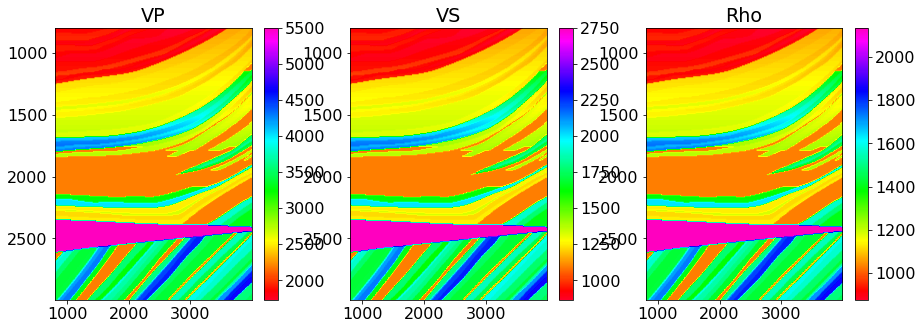

In [21]:
inputfile='../data/avo/poststack_model.npz'

model = np.load(inputfile)
x, z, m = model['x'][::3], model['z'], 1000*model['model'][:, ::3]
nx, nz = len(x), len(z)

m[(m>=2800)&(m<=3200)] = 2200

mvp = m.copy()
mvs = m/2
mrho = m/3+300

fig, axs = plt.subplots(1, 3, figsize=(15,5))
im=axs[0].imshow(mvp, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
              vmin=mvp.min(), vmax=mvp.max())
axs[0].set_title('VP')
axs[0].axis('tight')
plt.colorbar(im, ax=axs[0])
im=axs[1].imshow(mvs, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
              vmin=mvs.min(), vmax=mvs.max())
axs[1].set_title('VS')
plt.colorbar(im, ax=axs[1])
axs[1].axis('tight')
im=axs[2].imshow(mrho, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
              vmin=mrho.min(), vmax=mrho.max())
axs[2].set_title('Rho')
axs[2].axis('tight');
plt.colorbar(im, ax=axs[2]);

In [22]:
m = np.log(np.stack((mvp, mvs, mrho),axis=1))

# lop
PPop = PrestackLinearModelling(wav, theta, vsvp=vsvp, nt0=nz, 
                               spatdims=(nx,), linearization='akirich')
dottest(PPop, nz*ntheta*nx, nz*3*nx, verb=True)

# dense
PPop_dense = PrestackLinearModelling(wav, theta, vsvp=vsvp, nt0=nz, 
                                     spatdims=(nx,), linearization='akirich', explicit=True)
dottest(PPop_dense, nz*ntheta*nx, nz*3*nx, verb=True);

# lop
dPP = PPop*m.flatten()
dPP = dPP.reshape(nz,ntheta,nx)

# dense
dPP_dense = PPop_dense*m.swapaxes(0,1).flatten()
dPP_dense = dPP_dense.reshape(ntheta,nz,nx).swapaxes(0,1)

dPPn = dPP + np.random.normal(0, 5e-2, dPP_dense.shape)

Dot test passed, v^H(Opu)=230.2056115890755 - u^H(Op^Hv)=230.20561158910857
Dot test passed, v^H(Opu)=-85.34404895460483 - u^H(Op^Hv)=-85.34404895461913


In [23]:
Stack = block_diag(*[np.ones(npartial)/npartial for npartial in nthetas])
S = Transpose((len(nthetas), nz, np.prod((nx,))), (1, 0, 2)) * MatrixMult(Stack, (nz, nx)) * \
    Transpose((nz, ntheta, np.prod((nx,))), (1, 0, 2))
PPpartialop = S * PPop

PPmidop = PrestackLinearModelling(wav, thetas_mid, vsvp=vsvp, nt0=nz, 
                                  spatdims=(nx,), linearization='akirich')

101.89348651314965
0.0
103.73162280638857
1.3993112400852735e-14


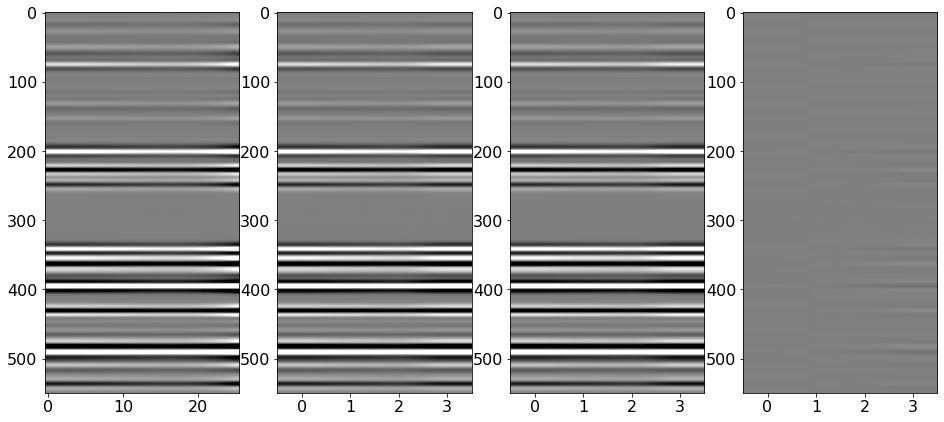

In [24]:
dPPmid = dPP[:, ithetas_mid] 
print(np.linalg.norm(dPP[:, ithetas_mid]))
print(np.linalg.norm(dPP[:, ithetas_mid].ravel() - (PPmidop * m.flatten())))

#dPPpartial = PPpartialop * m.T.flatten()
dPPpartial = np.array([np.sum(dPP[:, ithetas[i]:ithetas[i+1]], axis=1)/(ithetas[i+1]-ithetas[i]) 
                       for i in range(len(ithetas)-1)]).transpose(1, 0, 2)
print(np.linalg.norm(dPPpartial))
print(np.linalg.norm(dPPpartial.ravel() - PPpartialop * m.ravel()))

clip=0.2
fig, axs = plt.subplots(1, 4, figsize=(16, 7))
axs[0].imshow(dPP[..., nx//2], cmap='gray', vmin=-clip*dPP.max(), vmax=clip*dPP.max())
axs[0].axis('tight')
axs[1].imshow(dPPmid[..., nx//2], cmap='gray', vmin=-clip*dPP.max(), vmax=clip*dPP.max())
axs[1].axis('tight')
axs[2].imshow(dPPpartial[..., nx//2], cmap='gray', vmin=-clip*dPP.max(), vmax=clip*dPP.max())
axs[2].axis('tight')
axs[3].imshow(dPPmid[..., nx//2] - dPPpartial[..., nx//2],
              cmap='gray', vmin=-clip*dPP.max(), vmax=clip*dPP.max())
axs[3].axis('tight');

In [25]:
dPPnmid = dPPn[:, ithetas_mid] 

dPPnpartial = np.array([np.sum(dPPn[:, ithetas[i]:ithetas[i+1]], axis=1)/(ithetas[i+1]-ithetas[i]) 
                       for i in range(len(ithetas)-1)]).transpose(1, 0, 2)

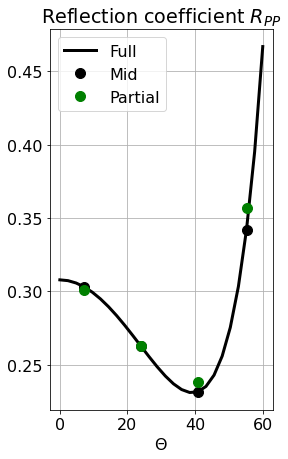

In [26]:
plt.figure(figsize=(4,7))
plt.plot(theta, dPP[200,:,nx//2], 'k', lw=3, label='Full')
plt.plot(thetas_mid, dPPmid[200,:,nx//2], '.k', ms=20, label='Mid')
plt.plot(thetas_mid, dPPpartial[200,:,nx//2], '.g', ms=20, label='Partial')
plt.xlabel(r'$\Theta$')
plt.title(r'Reflection coefficient $R_{PP}$')
plt.grid()
plt.legend();

In [27]:
nsmooth=15
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m, axis=0)
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, mback, axis=2)

dPP_0 = PPop * mback.flatten()
dPP_r = dPP.flatten() - dPP_0

dPPmid_0 = PPmidop * mback.flatten()
dPmid_r = dPPpartial.flatten() - dPPmid_0

dPPpartial_0 = PPpartialop * mback.flatten()
dPPpartial_r = dPPpartial.flatten() - dPPpartial_0

minvdense = lstsq(PPop_dense.A, 
                  dPP_r.reshape(nz,ntheta,nx).swapaxes(0,1).reshape(nz*ntheta,nx), 
                  cond=1e-5)[0]
minvdense = minvdense.reshape(3, nz, nx).swapaxes(0,1)
minvdense = mback + minvdense

minv = lsqr(PPop, dPP_r, damp=1e-5, iter_lim=30)[0]
minv = minv.reshape(nz, 3, nx)
minv = mback + minv

minvmid = lsqr(PPmidop, dPmid_r, damp=1e-5, iter_lim=30)[0]
minvmid = minvmid.reshape(nz, 3, nx)
minvmid = mback + minvmid

minvpartial = lsqr(PPpartialop, dPPpartial_r, damp=1e-5, iter_lim=30)[0]
minvpartial = minvpartial.reshape(nz, 3, nx)
minvpartial = mback + minvpartial

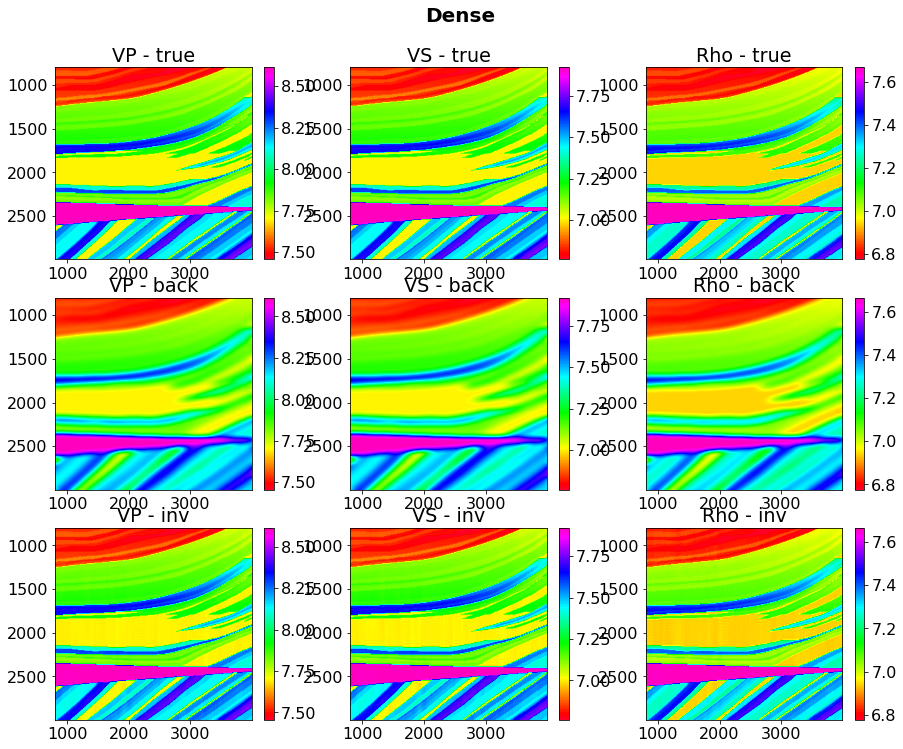

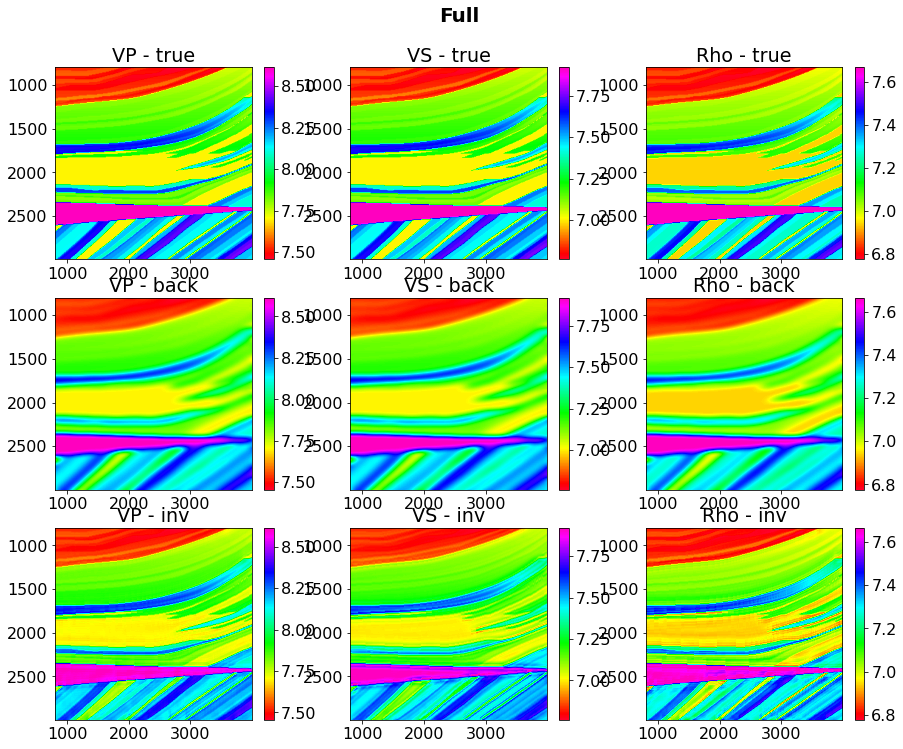

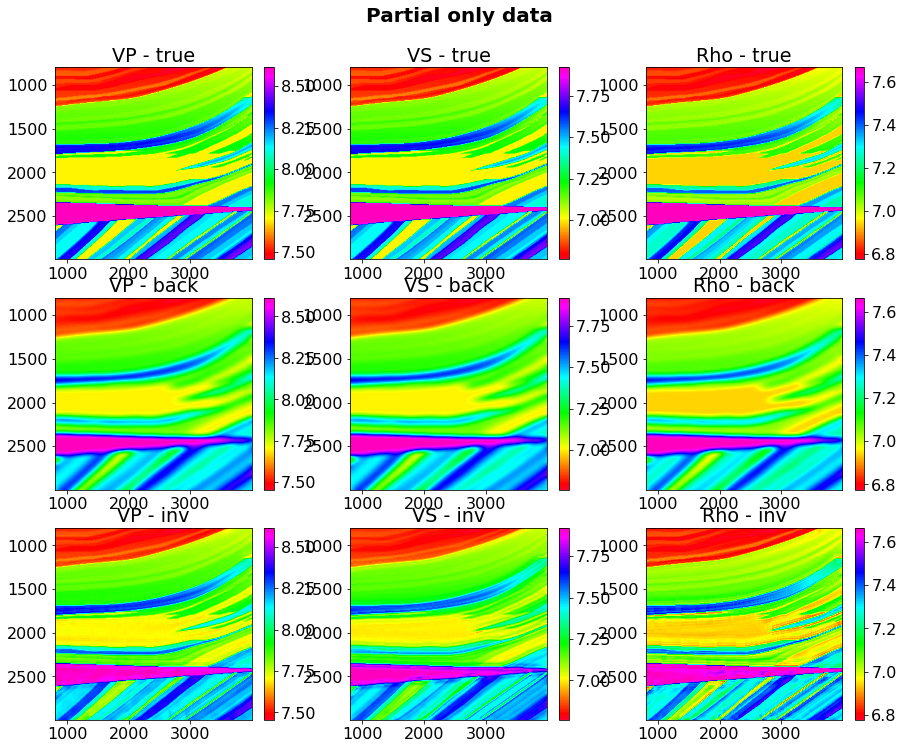

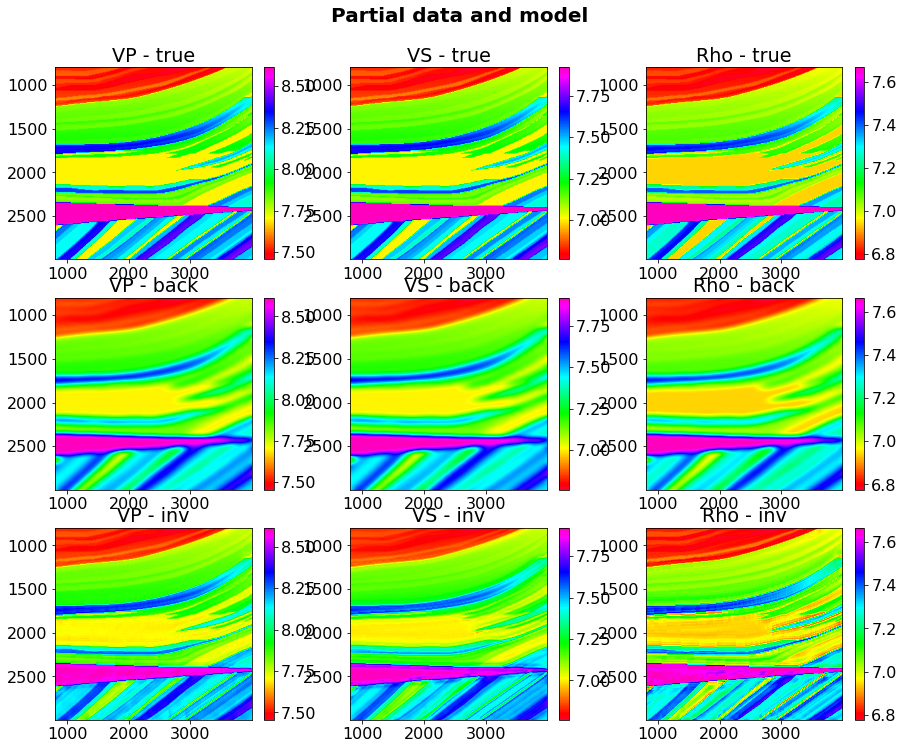

In [28]:
plotinversion(m, mback, minvdense, params = ['VP', 'VS', 'Rho'], title='Dense')

plotinversion(m, mback, minv, params = ['VP', 'VS', 'Rho'], title='Full')
plotinversion(m, mback, minvmid, params = ['VP', 'VS', 'Rho'], title='Partial only data')
plotinversion(m, mback, minvpartial, params = ['VP', 'VS', 'Rho'], 
              title='Partial data and model')

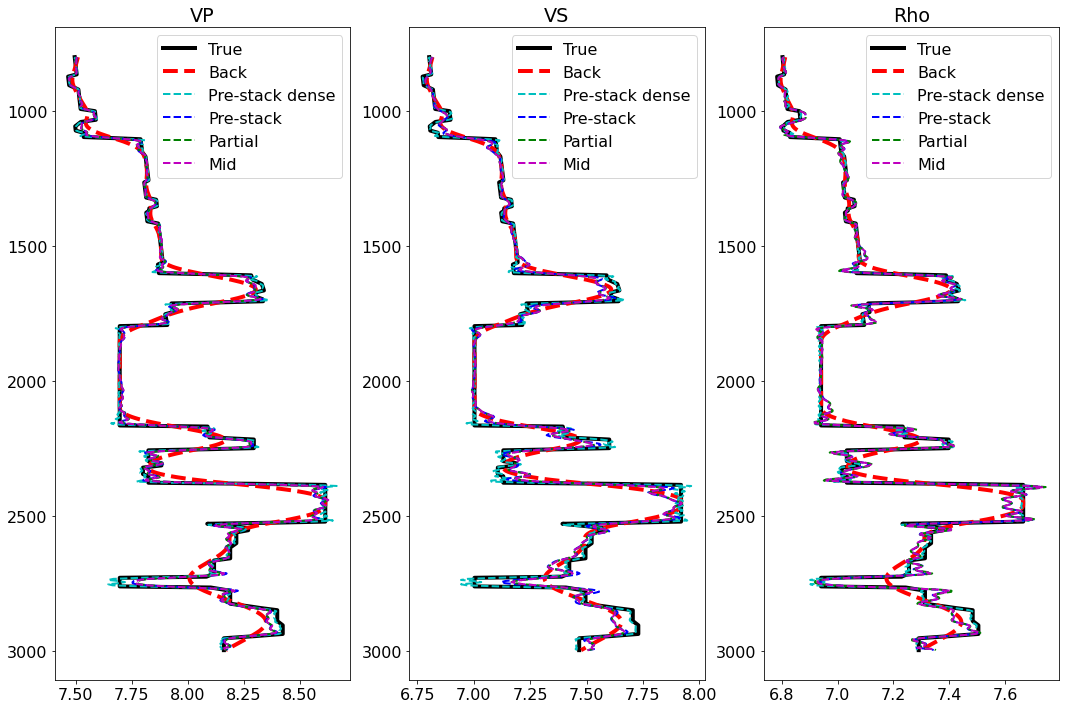

In [29]:
params = ['VP', 'VS', 'Rho']
fig, axs = plt.subplots(1, 3, figsize=(18, 12))
for ip, param in enumerate(params):
    axs[ip].plot(m[:, ip, nx//2], z, 'k', lw=4, label='True')
    axs[ip].plot(mback[:, ip, nx//2], z, '--r', lw=4, label='Back')
    axs[ip].plot(minvdense[:, ip, nx//2], z, '--c', lw=2, label='Pre-stack dense')
    axs[ip].plot(minv[:, ip, nx//2], z, '--b', lw=2, label='Pre-stack')
    axs[ip].plot(minvpartial[:, ip, nx//2], z, '--g', lw=2, label='Partial')
    axs[ip].plot(minvmid[:, ip, nx//2], z, '--m', lw=2, label='Mid')
    axs[ip].set_title(param)
    axs[ip].invert_yaxis()
    axs[ip].legend()

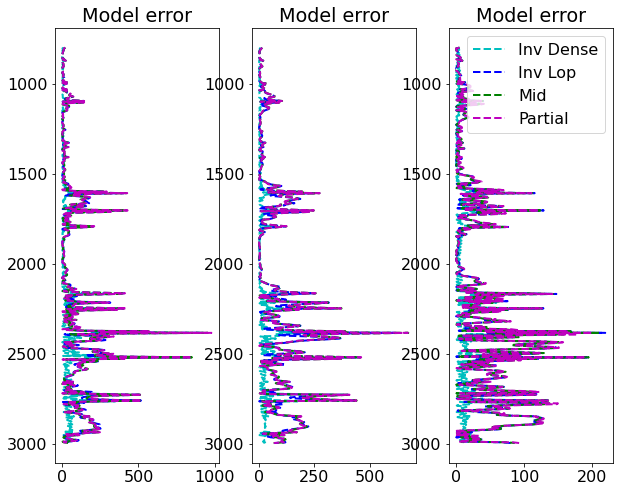

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(10, 8))
axs[0].plot(np.abs(mvp[:,nx//2]-np.exp(minvdense[:,0,nx//2])), z, '--c', lw=2, label='Inv Dense')
axs[0].plot(np.abs(mvp[:,nx//2]-np.exp(minv[:,0,nx//2])), z, '--b', lw=2, label='Inv Lop')
axs[0].plot(np.abs(mvp[:,nx//2]-np.exp(minvmid[:,0,nx//2])), z, '--g', lw=2, label='Mid')
axs[0].plot(np.abs(mvp[:,nx//2]-np.exp(minvpartial[:,0,nx//2])), z, '--m', lw=2, label='Partial')
axs[0].set_title('Model error')
axs[0].invert_yaxis()
axs[1].plot(np.abs(mvs[:,nx//2]-np.exp(minvdense[:,1,nx//2])), z, '--c', lw=2, label='Inv Dense')
axs[1].plot(np.abs(mvs[:,nx//2]-np.exp(minv[:,1,nx//2])), z, '--b', lw=2, label='Inv Lop')
axs[1].plot(np.abs(mvs[:,nx//2]-np.exp(minvmid[:,1,nx//2])), z, '--g', lw=2, label='Mid')
axs[1].plot(np.abs(mvs[:,nx//2]-np.exp(minvpartial[:,1,nx//2])), z, '--m', lw=2, label='Partial')
axs[1].set_title('Model error')
axs[1].invert_yaxis()
axs[1].axis('tight')
axs[2].plot(np.abs(mrho[:,nx//2]-np.exp(minvdense[:,2,nx//2])), z, '--c', lw=2, label='Inv Dense')
axs[2].plot(np.abs(mrho[:,nx//2]-np.exp(minv[:,2,nx//2])), z, '--b', lw=2, label='Inv Lop')
axs[2].plot(np.abs(mrho[:,nx//2]-np.exp(minvmid[:,2,nx//2])), z, '--g', lw=2, label='Mid')
axs[2].plot(np.abs(mrho[:,nx//2]-np.exp(minvpartial[:,2,nx//2])), z, '--m', lw=2, label='Partial')
axs[2].set_title('Model error')
axs[2].invert_yaxis()
axs[2].axis('tight')
axs[2].legend();

In [31]:
print(np.linalg.norm(mvp-np.exp(minvdense[:, 0])),
      np.linalg.norm(mvp-np.exp(minv[:, 0])),
      np.linalg.norm(mvp-np.exp(minvmid[:, 0])),
      np.linalg.norm(mvp-np.exp(minvpartial[:, 0])))

print(np.linalg.norm(mvs-np.exp(minvdense[:, 1])),
      np.linalg.norm(mvs-np.exp(minv[:, 1])),
      np.linalg.norm(mvs-np.exp(minvmid[:, 1])),
      np.linalg.norm(mvs-np.exp(minvpartial[:, 1])))

print(np.linalg.norm(mrho-np.exp(minvdense[:, 2])),
      np.linalg.norm(mrho-np.exp(minv[:, 2])),
      np.linalg.norm(mrho-np.exp(minvmid[:, 2])),
      np.linalg.norm(mrho-np.exp(minvpartial[:, 2])))

25822.392801046863 52518.50637997579 52319.154867353755 53951.153831007614
14487.696785166105 41617.608332190604 44334.553997623414 43973.57975704189
8709.091629887862 19129.21164049926 19453.698571603687 20124.213175689914


In [32]:
dPPn_r = dPPn.flatten() - dPP_0
dPnmid_r = dPPnpartial.flatten() - dPPmid_0
dPPnpartial_r = dPPnpartial.flatten() - dPPpartial_0

minvn = lsqr(PPop, dPPn_r, damp=1e-2, iter_lim=30)[0]
minvn = minvn.reshape(nz, 3, nx)
minvn = mback + minvn

minvmidn = lsqr(PPmidop, dPnmid_r, damp=1e-2, iter_lim=30)[0]
minvmidn = minvmidn.reshape(nz, 3, nx)
minvmidn = mback + minvmidn

minvpartialn = lsqr(PPpartialop, dPPnpartial_r, damp=1e-2, iter_lim=30)[0]
minvpartialn = minvpartialn.reshape(nz, 3, nx)
minvpartialn = mback + minvpartialn

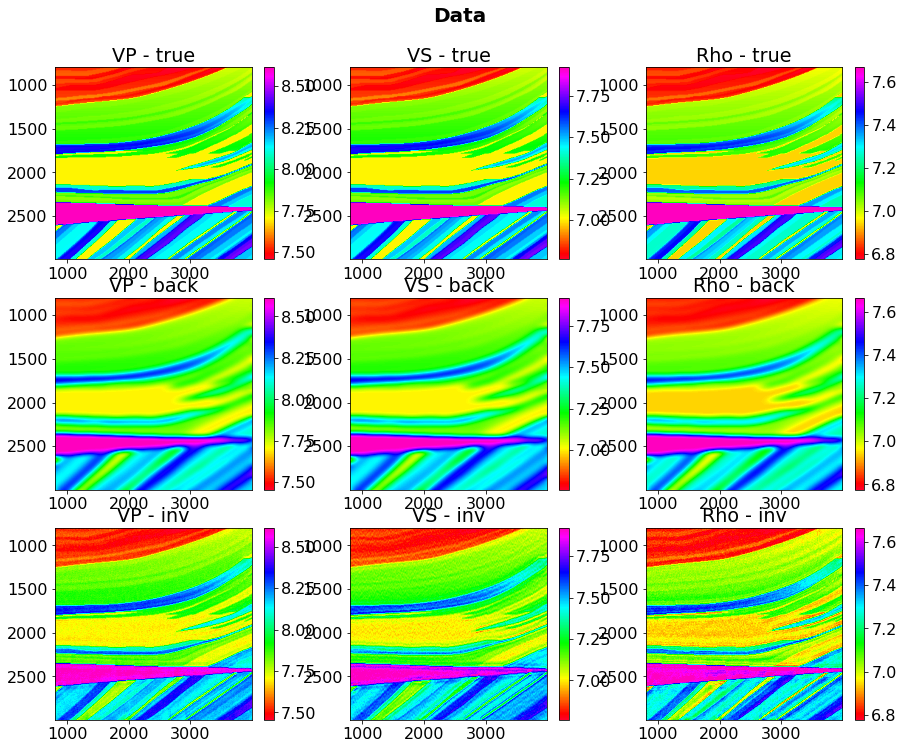

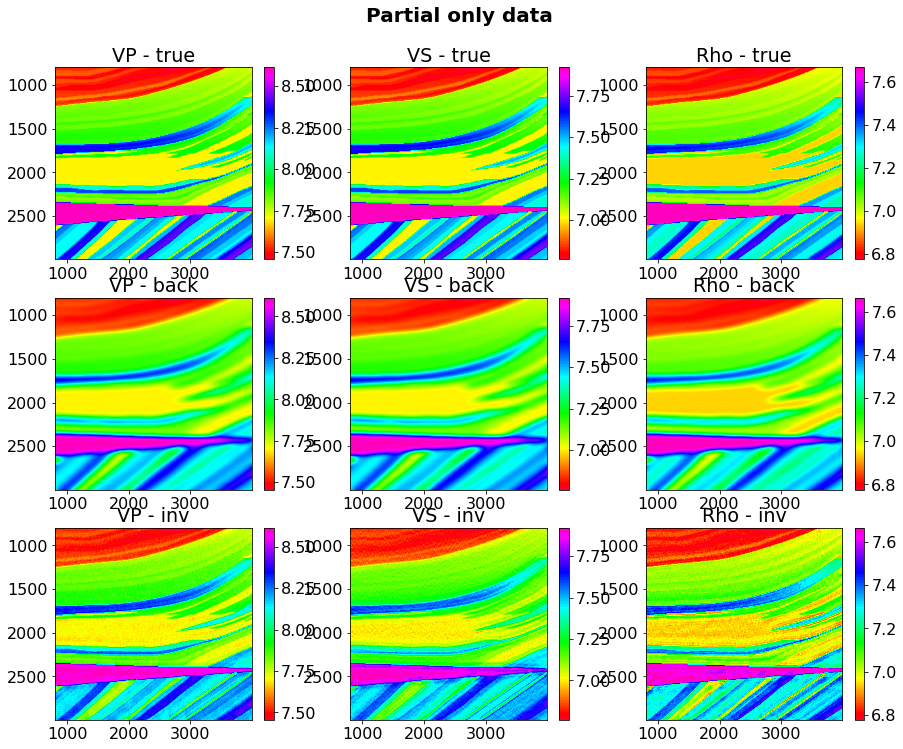

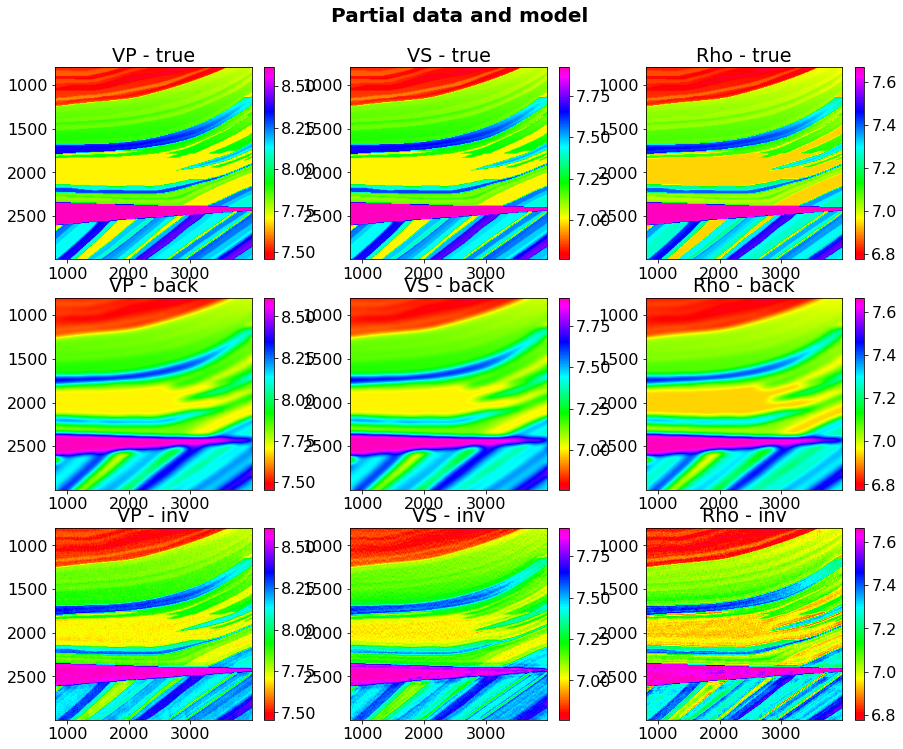

In [33]:
plotinversion(m, mback, minvn, params = ['VP', 'VS', 'Rho'], title='Data')
plotinversion(m, mback, minvmidn, params = ['VP', 'VS', 'Rho'], title='Partial only data')
plotinversion(m, mback, minvpartialn, params = ['VP', 'VS', 'Rho'], 
              title='Partial data and model')

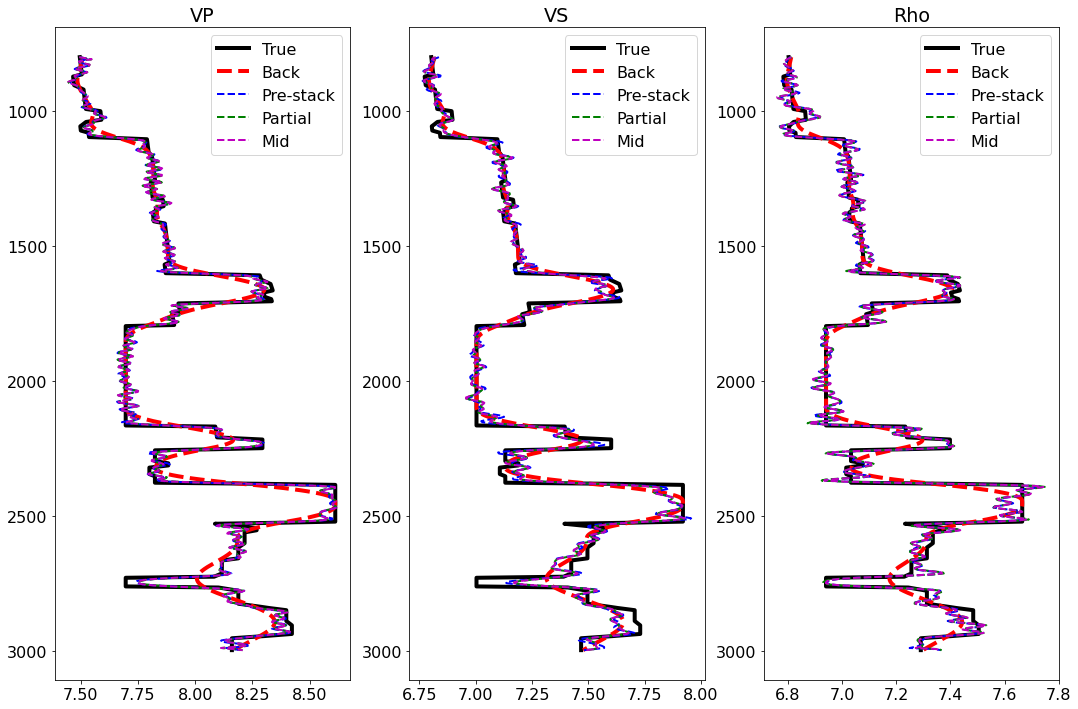

In [34]:
params = ['VP', 'VS', 'Rho']
fig, axs = plt.subplots(1, 3, figsize=(18, 12))
for ip, param in enumerate(params):
    axs[ip].plot(m[:, ip, nx//2], z, 'k', lw=4, label='True')
    axs[ip].plot(mback[:, ip, nx//2], z, '--r', lw=4, label='Back')
    axs[ip].plot(minvn[:, ip, nx//2], z, '--b', lw=2, label='Pre-stack')
    axs[ip].plot(minvpartialn[:, ip, nx//2], z, '--g', lw=2, label='Partial')
    axs[ip].plot(minvmidn[:, ip, nx//2], z, '--m', lw=2, label='Mid')
    axs[ip].set_title(param)
    axs[ip].invert_yaxis()
    axs[ip].legend()

In [35]:
print(np.linalg.norm(mvp-np.exp(minvn[:, 0])),
      np.linalg.norm(mvp-np.exp(minvmidn[:, 0])),
      np.linalg.norm(mvp-np.exp(minvpartialn[:, 0])))

print(np.linalg.norm(mvs-np.exp(minvn[:, 1])),
      np.linalg.norm(mvs-np.exp(minvmidn[:, 1])),
      np.linalg.norm(mvs-np.exp(minvpartialn[:, 1])))

print(np.linalg.norm(mrho-np.exp(minvn[:, 2])),
      np.linalg.norm(mrho-np.exp(minvmidn[:, 2])),
      np.linalg.norm(mrho-np.exp(minvpartialn[:, 2])))

55990.50962230462 56206.16328924734 57508.07236791378
43360.062886732485 45592.70255527667 45174.03184395022
21417.90578615367 21887.678923737796 22436.23198222537
